# Stock Price Prediction Using alphavantage Api

## Overview


In [2]:
!pip install python-dateutil

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/python3/bin/python -m pip install --upgrade pip' command.


In [3]:
import os
import io
import boto3
import sagemaker
import datetime
import pandas as pd
from pandas.plotting import autocorrelation_plot
from pandas.plotting import scatter_matrix
import matplotlib
import matplotlib.pyplot as plt
 
from dateutil import parser

%matplotlib inline

## Define IAM role and session
role = sagemaker.get_execution_role()
session = sagemaker.Session()

s3_data_key = 'dbg-stockdata/source'
s3_bucket = 'alphavantage-dcap' #session.default_bucket()
print(s3_bucket)
processed_filename = 'dbg_processed'

#source_bucket = "s3://deutsche-boerse-xetra-pds"

alphavantage-dcap


## 1. Obtaining Data

Since the DBG dataset is partitioned into separate folders by date, we generate a series of scripts to download the data files, in parallel.

DBG dataset contains trading data beginning June-17, 2017. However we chose to download last 6 months of data, so that the processing time is manageable within the scope of this workshop session.


In [4]:
start_date = datetime.datetime.strptime('2020-04-29','%Y-%m-%d')

end_date = datetime.datetime.strptime('2020-10-23','%Y-%m-%d')


end_date_str = end_date.strftime('%Y-%m-%d')
start_date_str = start_date.strftime('%Y-%m-%d')

print("Download date range: {} - {}".format(start_date_str, end_date_str))


Download date range: 2020-04-29 - 2020-10-23


We store all files in a local folder, prior to pre-processing the data. <br>
After processing, we store the processed data set in another folder, which we'll then upload to an our SageMaker S3 bucket.


In [5]:
download_folder = '../data/download'
processed_folder = '../data/processed'
! mkdir -p {download_folder}
! mkdir -p {processed_folder}

We then generate the download script in script folder and execute it to have the files downloaded.<br>
Running bash script makes the download more reliable than running loops from Pythin runtime.

In [6]:
%%time
import pandas as pd
import matplotlib.pyplot as plt

from enum import Enum  

Adjusted = Enum('Adjusted', 'true false')
Interval = Enum('Interval', '_1min _5min _15min _30min _60min')
OutputSize = Enum('outputsize', 'compact full')
DataType = Enum('datatype', 'json csv')

def Slice(year, month):
    return 'year{}month{}'.format(year, month) 

def GetInterval(interval):
    return interval.name[1:] 
 
key = '7YVKV6R8YWNYE83E'
apiUrl = 'https://www.alphavantage.co/query'

def Time_Series_Intraday_Extended(symbol,interval,slice,adjusted,key):
    url = '{}?function=TIME_SERIES_INTRADAY_EXTENDED&symbol={}&interval={}&slice={}&adjusted={}&apikey={}'
    fileName = '../data/download/{}-{}-{}.csv'.format(symbol,GetInterval(interval), slice)

    #print (url.format(apiUrl, symbol, GetInterval(interval), slice, adjusted, key))
    data = pd.read_csv(url.format(apiUrl, symbol, GetInterval(interval), slice, adjusted, key))

    data=data.rename(columns={"open": "StartPrice", "high": "MaxPrice", "low":"MinPrice","close":"EndPrice", "volume":"TradedVolume","time":"OldTime"})
    data['Mnemonic']=symbol
    data['ISIN']=''
    data['SecurityDesc']=''
    data['SecurityType']='Common stock'
    data['Currency']=''
    data['SecurityID']=''
    data['NumberOfTrades'] = 1
    data['Time']=''
    data['Date']=''
    
    data.set_index('OldTime', inplace=True)
    
    for i in data.index:
        time = parser.parse(i) 
        data.at[i, 'Time'] =  time.time()
        data.at[i, 'Date'] =  time.date()
    
       
    #print(data)    
    data.to_csv(fileName)
    print ('{},{}'.format(fileName, data.shape))

for symbol in ['IBM','AAPL','MSFT','AMZN', 'GOOG','GOOGL','FB', 'MMC']:
#for symbol in ['IBM']:
    for year in range(1,2):
        for month in range(1,13):
            Time_Series_Intraday_Extended(symbol, Interval._1min, Slice(year,month), Adjusted.false, key)

../data/download/IBM-1min-year1month1.csv,(9310, 14)
../data/download/IBM-1min-year1month2.csv,(8856, 14)
../data/download/IBM-1min-year1month3.csv,(9263, 14)
../data/download/IBM-1min-year1month4.csv,(8961, 14)
../data/download/IBM-1min-year1month5.csv,(9233, 14)
../data/download/IBM-1min-year1month6.csv,(9026, 14)
../data/download/IBM-1min-year1month7.csv,(9512, 14)
../data/download/IBM-1min-year1month8.csv,(9340, 14)
../data/download/IBM-1min-year1month9.csv,(9455, 14)
../data/download/IBM-1min-year1month10.csv,(8757, 14)
../data/download/IBM-1min-year1month11.csv,(7937, 14)
../data/download/IBM-1min-year1month12.csv,(8010, 14)
../data/download/AAPL-1min-year1month1.csv,(18158, 14)
../data/download/AAPL-1min-year1month2.csv,(19333, 14)
../data/download/AAPL-1min-year1month3.csv,(16949, 14)
../data/download/AAPL-1min-year1month4.csv,(14489, 14)
../data/download/AAPL-1min-year1month5.csv,(15211, 14)
../data/download/AAPL-1min-year1month6.csv,(15183, 14)
../data/download/AAPL-1min-year

After creating the script, we run the script from shell, using Jupyter magic command.

Downloading data should take about half an hour to an hour to complete depending on the dat range chosen.

In order to avoid this process, you can alternative use the last cell in this notebook to obtain the prepared data from an S3 bucket accompanying this workshop, and load directly to your own S3 bucket.

## 2. Data Preparation

To prepare the data, we collect day wise tading data from separate files, filter out any data falling out of trading window, and not pertaining to common stock trading.

### 2.1. Load Data
As first step we load all csv files in to a single data frame.

Data loading should take about 1-2 hours to complete depending on the instance type you have chosen for your notebook instance.

In [7]:
%%time
dates = ['MSFT']
def convert_datetime(df):
    try: 
        df["CalcTime"] = pd.to_datetime("1900-01-01 " + df["Time"])
        df["CalcDateTime"] = pd.to_datetime(df["Date"] + " " + df["Time"])
    except:
        print('error')
        pass
    return df

def load_csvs(data_folder):
    print(data_folder)
    df = None
    total_loaded = 0
    df_initialized = False
    data_dir = data_folder + '/'
    data_subdirs = [data_folder]
    print(data_subdirs)
    for d in data_subdirs:
        trading_files = sorted(list(filter(lambda x:os.path.getsize(x)>2000, [os.path.join(d, x) for x in os.listdir(d) if x.endswith('.csv')])))    
        print(trading_files)
        if len(trading_files) > 0:
            print("Loading {} files from {}".format(len(trading_files), d))
            if df_initialized == False:
                frame = [pd.read_csv(f, engine='python', error_bad_lines=False, warn_bad_lines=False) for f in trading_files]
                df = convert_datetime(pd.concat(frame, ignore_index = True))
                df_initialized = True
            else:
                dfa = convert_datetime(pd.concat([pd.read_csv(f, engine='python', error_bad_lines=False) for f in trading_files], ignore_index = True))
                dft = [df, dfa]
                df = pd.concat(dft, ignore_index = True)
            total_loaded = total_loaded + len(trading_files)
    print("Total of {} files loaded".format(total_loaded))
    return df
unprocessed_df = load_csvs(download_folder)

../data/download
['../data/download']
['../data/download/AAPL-1min-year1month1.csv', '../data/download/AAPL-1min-year1month10.csv', '../data/download/AAPL-1min-year1month11.csv', '../data/download/AAPL-1min-year1month12.csv', '../data/download/AAPL-1min-year1month2.csv', '../data/download/AAPL-1min-year1month3.csv', '../data/download/AAPL-1min-year1month4.csv', '../data/download/AAPL-1min-year1month5.csv', '../data/download/AAPL-1min-year1month6.csv', '../data/download/AAPL-1min-year1month7.csv', '../data/download/AAPL-1min-year1month8.csv', '../data/download/AAPL-1min-year1month9.csv', '../data/download/AMZN-1min-year1month1.csv', '../data/download/AMZN-1min-year1month10.csv', '../data/download/AMZN-1min-year1month11.csv', '../data/download/AMZN-1min-year1month12.csv', '../data/download/AMZN-1min-year1month2.csv', '../data/download/AMZN-1min-year1month3.csv', '../data/download/AMZN-1min-year1month4.csv', '../data/download/AMZN-1min-year1month5.csv', '../data/download/AMZN-1min-year1mo

In [8]:
unprocessed_df.head()

,OldTime,StartPrice,MaxPrice,MinPrice,EndPrice,TradedVolume,Mnemonic,ISIN,SecurityDesc,SecurityType,Currency,SecurityID,NumberOfTrades,Time,Date,CalcTime,CalcDateTime
0,2020-10-23 20:00:00,115.06,115.10,115.05,115.09,3819,AAPL,NaN,NaN,Common stock,NaN,NaN,1,20:00:00,2020-10-23,1900-01-01 20:00:00,2020-10-23 20:00:00
1,2020-10-23 19:59:00,115.06,115.10,115.05,115.09,9316,AAPL,NaN,NaN,Common stock,NaN,NaN,1,19:59:00,2020-10-23,1900-01-01 19:59:00,2020-10-23 19:59:00
2,2020-10-23 19:58:00,115.07,115.09,115.04,115.06,3244,AAPL,NaN,NaN,Common stock,NaN,NaN,1,19:58:00,2020-10-23,1900-01-01 19:58:00,2020-10-23 19:58:00
3,2020-10-23 19:57:00,115.07,115.08,115.02,115.06,6700,AAPL,NaN,NaN,Common stock,NaN,NaN,1,19:57:00,2020-10-23,1900-01-01 19:57:00,2020-10-23 19:57:00
4,2020-10-23 19:56:00,115.05,115.07,115.05,115.06,2047,AAPL,NaN,NaN,Common stock,NaN,NaN,1,19:56:00,2020-10-23,1900-01-01 19:56:00,2020-10-23 19:56:00


### 2.2. Filter records
Next we filter the records pertaining to common stack with trading volumes greater than zero, and within the regular trading hours.
Within the scope of this exercise, we focus our attention to top 100 stocks, by trading volume.

This filtering should take about 1-2 minute to complete depending on the instance type you have chosen for your notebook instance.

In [9]:
%%time
# Filter common stock between trading hours 08:00 and 20:00
# Exclude auctions (those are with TradeVolume == 0)
#Number of stocks to keep : Top 100, by trading volume
num_stocks=100
time_fmt = "%H:%M"
opening_hours_str = "08:00"
closing_hours_str = "20:00"
opening_hours = datetime.datetime.strptime(opening_hours_str, time_fmt)
closing_hours = datetime.datetime.strptime(closing_hours_str, time_fmt)

common_stocks = unprocessed_df[(unprocessed_df.SecurityType == 'Common stock') & \
                    (unprocessed_df.TradedVolume > 0) & \
                    (unprocessed_df.CalcTime >= opening_hours) & \
                    (unprocessed_df.CalcTime <= closing_hours)]

# Sort the stocks in descending order by trading volume
sort_by_volume = common_stocks[['Mnemonic', 'TradedVolume']].groupby(['Mnemonic']).sum().sort_values(['TradedVolume'], ascending=[0]).head(num_stocks)
stock_symbols = list(sort_by_volume.index.values)
sorted_stocks = common_stocks[common_stocks.Mnemonic.isin(stock_symbols)]
sorted_stocks = sorted_stocks.set_index(['Mnemonic', 'CalcDateTime']).sort_index()
stock_symbols = list(sort_by_volume.index.values)
print(sorted_stocks.shape)

(956045, 15)
CPU times: user 800 ms, sys: 519 ms, total: 1.32 s
Wall time: 1.32 s


Check to see how many days' records we imported. If you import all records starting from July-2017, to October-2018, it should contain 326 days' woth of records.

In [10]:
len(sorted(list(sorted_stocks['Date'].unique())))

247

### 2.3. Select features by minute

Next we build a clean data frame containing minute by minute transaction records with the following data points:
- Mnemonic (Stock Ticker Symbol)
- Minimum Price (During the interval)
- Maximum Prixe (During the interval)
- Start Price (At star of the interval)
- End Price (At end of the interval)
- Trading Volume (During the interval)
- Number of Trades (During the interval)

In [11]:
%%time
#Build minute by minute index for trading hours
non_empty_days = sorted(list(sorted_stocks['Date'].unique()))
def build_index(non_empty_days, from_time, to_time):
    date_ranges = []
    for date in non_empty_days:
        yyyy, mm, dd = date.split('-')
        from_hour, from_min = from_time.split(':')
        to_hour, to_min = to_time.split(':')    
        t1 = datetime.datetime(int(yyyy), int(mm), int(dd), int(from_hour),int(from_min),0)
        t2 = datetime.datetime(int(yyyy), int(mm), int(dd), int(to_hour),int(to_min),0) 
        date_ranges.append(pd.DataFrame({"OrganizedDateTime": pd.date_range(t1, t2, freq='1Min').values}))
    agg = pd.concat(date_ranges, axis=0) 
    agg.index = agg["OrganizedDateTime"]
    return agg

# Prepared data would contain numeric features for all stocks,
# for all days in the interval, for which there were trades (that means excluding weekends and holidays)
# for all minutes from 08:00 until 20:00
# in minutes without trades the prices from the last available minute are carried forward
# trades are filled with zero for such minutes

def basic_stock_features(input_df, mnemonic, time_index):
    stock = input_df.loc[mnemonic].copy()
    stock['HasTrade'] = 1.0    
    stock = stock.reindex(time_index)    
    features = ['MinPrice', 'MaxPrice', 'EndPrice', 'StartPrice']
    for f in features:
        stock[f] = stock[f].fillna(method='ffill')       
    features = ['HasTrade', 'TradedVolume', 'NumberOfTrades']
    for f in features:
        stock[f] = stock[f].fillna(0.0)    
    stock['Mnemonic'] = mnemonic
    selected_features = ['Mnemonic', 'MinPrice', 'MaxPrice', 'StartPrice', 'EndPrice', 'HasTrade', 'TradedVolume', 'NumberOfTrades']
    return stock[selected_features]

datetime_index = build_index(non_empty_days, opening_hours_str, closing_hours_str)["OrganizedDateTime"].values

stocks = []
for stock in stock_symbols:
    stock = basic_stock_features(sorted_stocks, stock, datetime_index)
    stocks.append(stock)

prepared = pd.concat(stocks, axis=0)
prepared.insert(0, 'Id', range(0, 0 + len(prepared)))
prepared = prepared.reset_index().set_index('Id')

CPU times: user 1.08 s, sys: 292 ms, total: 1.37 s
Wall time: 1.37 s


In [12]:
prepared.head()

,CalcDateTime,Mnemonic,MinPrice,MaxPrice,StartPrice,EndPrice,HasTrade,TradedVolume,NumberOfTrades
Id,,,,,,,,,
0,2019-11-01 08:00:00,AAPL,61.540789,61.563069,61.548216,61.540789,1.0,27168.0,1.0
1,2019-11-01 08:01:00,AAPL,61.540789,61.738829,61.719025,61.565544,1.0,170208.0,1.0
2,2019-11-01 08:02:00,AAPL,61.548216,61.563069,61.563069,61.558118,1.0,4816.0,1.0
3,2019-11-01 08:03:00,AAPL,61.545988,61.553167,61.545988,61.553167,1.0,1540.0,1.0
4,2019-11-01 08:04:00,AAPL,61.555642,61.555642,61.555642,61.555642,1.0,1012.0,1.0


### 2.4. Save processed data
Finally we save the processed data and upload to our SageMaker S3 Bucket.<br>
Source data, as downloaded from DBG dataset includes minute by minute details of price movement and trading numbers and volumes for the stocks. However, in practice, we might be interested in time series at various aggregation level, in order to do more effective hourly, daily or weekly predictions.

Therefore we resample the data at various interval levels. First we define a resampling function that is able to resample various metrices for the aggregation levels.<br>
For example, at a certain interval level, we are interested in:<br>
- Last record for the End Price
- First record for the Start Price
- Minimum of all records for Min Price
- Maximum of all records for Max Price
- Total of all records for Number of Trades and Traded Volume

In [13]:
%%time
intervals = ['M', 'W', 'D', 'H']

def resample_data(df, interval = None, mnemonics=None, metrics=None):
    if mnemonics is None:
        mnemonics = list(df.Mnemonic.unique())
    if metrics is None:
        metrics = list(df.columns.values)
    if 'Mnemonic' in metrics:
        metrics.remove('Mnemonic')
    if 'HasTrade' in metrics:
        metrics.remove('HasTrade')        
        
    columns = list(df.columns.values)
    if 'CalcDateTime' not in columns:        
        df["CalcDateTime"] = pd.to_datetime(df["CalcDateTime"])
        
    if interval is None or not isinstance(interval, str) or interval not in intervals:
        raise ValueError('Interval not supported, must be one of : {}'.format(intervals))
        
    resampeled_frames = []         
    for mnemonic in mnemonics:
        print("Resampling {} records for interval - {}".format(mnemonic, interval))
        selected = df[df.Mnemonic == mnemonic].copy()
        selected.index = selected['CalcDateTime']
        selected = selected.sort_index()
        resampled = pd.DataFrame()   
        for metric in metrics:            
            if metric == 'EndPrice':
                resampled[metric] = selected[metric].resample(interval).last()
            elif metric == 'StartPrice':
                resampled[metric] = selected[metric].resample(interval).first()                   
            elif metric == 'MinPrice':
                resampled[metric] = selected[metric].resample(interval).min()                                 
            elif metric == 'MaxPrice':
                resampled[metric] = selected[metric].resample(interval).max()                                  
            elif metric == 'TradedVolume' or metric == "NumberOfTrades" :
                resampled[metric] = selected[metric].resample(interval).sum()                               
            else:
                pass
        resampled_columns = ['Mnemonic']
        for col in list(resampled.columns.values):
            resampled_columns.append(col)
        resampled['Mnemonic'] = mnemonic
        resampled = resampled[resampled_columns]  
        resampled.dropna(inplace = True)
        resampeled_frames.append(resampled)
    resampeleds = pd.concat(resampeled_frames)
    return resampeleds

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 8.58 µs


Next we do a resampling for the following intervals and upload the file to an appropriate S3 location directly, saving local disk space:
- Month
- Week
- Day
- Hour

Resampling of the time series data at four different interval levels should take about 10 to 20 minutes to complete, depending on the instance type you have chosen for your notebook instance.

Note that this causes gaps in time series. However SageMaker DeepAR algorithm is designed to work with time series with gaps.

In [14]:
%%time
for interval in intervals:
    rescaled_series = resample_data(prepared, interval)
    csv_buffer = io.StringIO()
    rescaled_series.to_csv(csv_buffer)
    s3_resource = boto3.resource('s3')
    s3_resource.Object(s3_bucket, '{}/{}/resampled_stockdata.csv'.format(s3_data_key, interval, interval)).put(Body=csv_buffer.getvalue())
    

Resampling AAPL records for interval - M
Resampling MSFT records for interval - M
Resampling FB records for interval - M
Resampling IBM records for interval - M
Resampling AMZN records for interval - M
Resampling MMC records for interval - M
Resampling GOOGL records for interval - M
Resampling GOOG records for interval - M
Resampling AAPL records for interval - W
Resampling MSFT records for interval - W
Resampling FB records for interval - W
Resampling IBM records for interval - W
Resampling AMZN records for interval - W
Resampling MMC records for interval - W
Resampling GOOGL records for interval - W
Resampling GOOG records for interval - W
Resampling AAPL records for interval - D
Resampling MSFT records for interval - D
Resampling FB records for interval - D
Resampling IBM records for interval - D
Resampling AMZN records for interval - D
Resampling MMC records for interval - D
Resampling GOOGL records for interval - D
Resampling GOOG records for interval - D
Resampling AAPL records f

Having the prepared data saved to an S3 bucket not only allows us to save some space in lcoal machine, but also helps when starting training job using SageMaker.<br>
Since reading from S3 is optimized for high speed, when you are using an EC2 instance, which is what a SageMaker Notebook instance runs on, it makes sense to just load the data directly from S3, as and when needed.<br><br>
Also, since SageMaker notebook instances come with only 5GB of Elastic Block Storage (to remain cost efficient), it is advisable to keep the device storage space clean, when not used.<br><br>
Therefore, we delete the raw data files locally, to conserve storage space on notebook instance.


In [15]:
%%time
#Remove the download folder
!rm -rf {download_folder}
#Reset the data frames loaded in memory
rescaled_series = None    
prepared = None
unprocessed_df = None

CPU times: user 60.8 ms, sys: 0 ns, total: 60.8 ms
Wall time: 181 ms


### 2.6. Validate Data Load from S3

Before moving on, we want to validate data by downloading from the location on S3 that we just saved, and run some quick introspection to develop an intuition about the nature of metrices and their possible influence on stock price movement.<br>
For our preliminary analysis, we choose to load and investigate data with daily interval.

In [16]:
%%time
def load_resampled_from_s3(interval, bucket, s3_data_key):
    s3 = boto3.client('s3')
    obj = s3.get_object(Bucket=bucket, Key="{}/{}/resampled_stockdata.csv".format(s3_data_key, interval))
    loaded = pd.read_csv(io.BytesIO(obj['Body'].read()), parse_dates=True)
    mnemonics = list(loaded.Mnemonic.unique())
 
    return loaded, mnemonics

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 7.63 µs


In [17]:
%%time
interval = "H"
stockdata, stocksymbols = load_resampled_from_s3(interval, s3_bucket, s3_data_key)


CPU times: user 62.5 ms, sys: 134 µs, total: 62.7 ms
Wall time: 132 ms


In [18]:
stockdata.head()

,CalcDateTime,Mnemonic,MinPrice,MaxPrice,StartPrice,EndPrice,TradedVolume,NumberOfTrades
0,2019-11-01 08:00:00,AAPL,61.540789,61.815569,61.548216,61.763584,828412.0,53.0
1,2019-11-01 09:00:00,AAPL,61.679417,62.372555,61.758633,62.288388,25648780.0,60.0
2,2019-11-01 10:00:00,AAPL,62.196795,62.810718,62.290814,62.696845,30342672.0,60.0
3,2019-11-01 11:00:00,AAPL,62.630007,62.825571,62.698083,62.698083,15136088.0,60.0
4,2019-11-01 12:00:00,AAPL,62.516877,62.706747,62.699321,62.533462,13100628.0,60.0


### Data exploration
At the end, we do a quick check on the data, and plot some series to develop an intuition of what the data looks like.

In [19]:
%%time
matplotlib.rcParams['figure.figsize'] = (25, 17) # use bigger graphs
def timeseries_plot(mnemonics, metrics, data=None, interval = None, bucket = None, s3_key = None):
    if data is None and interval is not None and bucket is not None and s3_key is not None:
        data, symbols = load_resampled_from_s3(interval, bucket, s3_key)      
    columns = list(data.columns)
    ax = None
    for mnemonic in mnemonics:
        selected = data[data.Mnemonic == mnemonic].copy()
        selected.index = selected['CalcDateTime']
        selected = selected.sort_index()
        for column in columns:
            if column != 'CalcDateTime' and column != 'Mnemonic' and column not in metrics:
                selected = selected.drop(column, axis=1)
        selected_columns = list(selected.columns)
        for i, column in enumerate(selected_columns):
            selected_columns[i] = "{}-{}".format(mnemonic, column)
        selected.columns = selected_columns
        ax = selected.plot( ax = ax )

CPU times: user 44 µs, sys: 0 ns, total: 44 µs
Wall time: 48.4 µs


Let's plot ending price for 3 automobile companies - BMW, Daimler, Porsche, Volkwagen

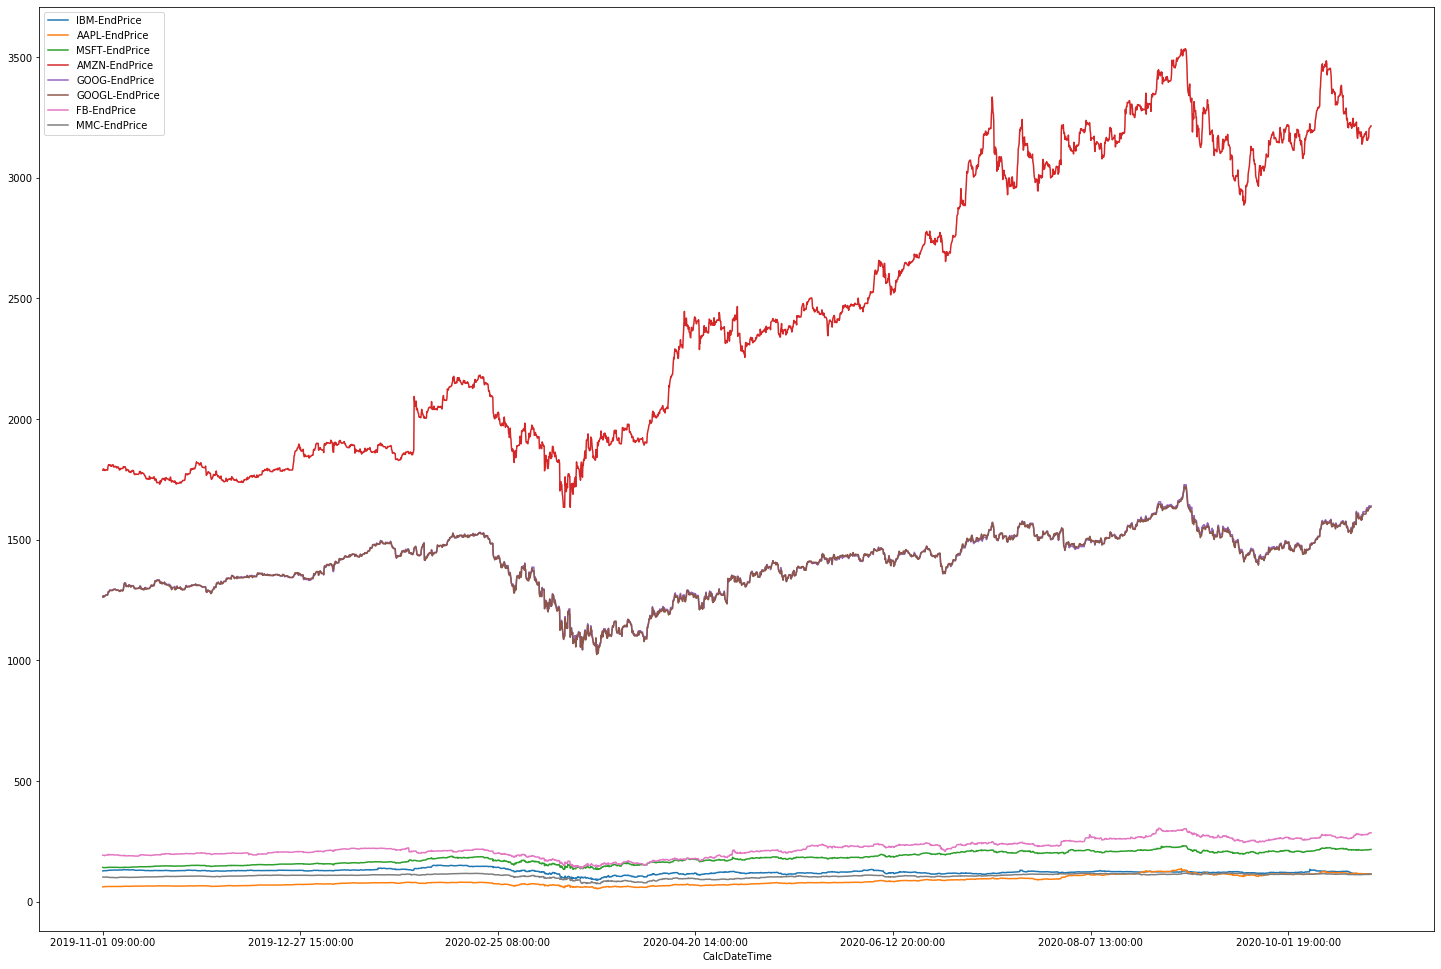

In [26]:
timeseries_plot(['IBM','AAPL','MSFT','AMZN', 'GOOG','GOOGL','FB', 'MMC'], ['EndPrice'], stockdata)

Observe here since the four stocks we chose to display are all automobile companies, their movements show very similar pattern.

We can also choose to display these stocks at lower resolution, such as at weekly interval, and still be able to observe the same patter.

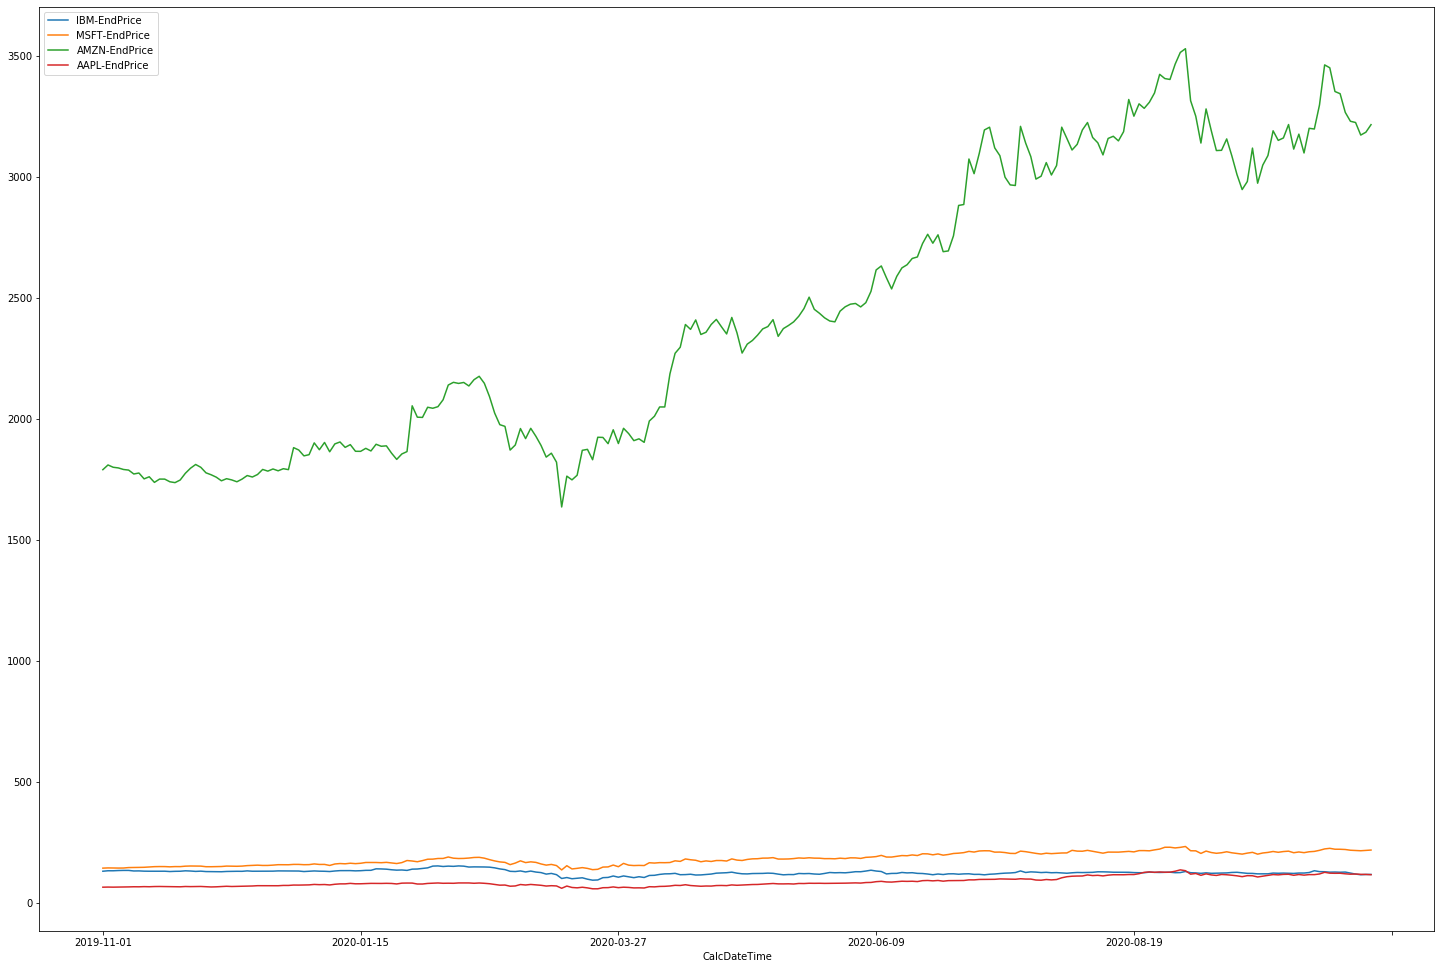

In [21]:
timeseries_plot(['IBM', 'MSFT', 'AMZN', 'AAPL'], ['EndPrice'], interval = 'D', bucket = s3_bucket, s3_key = s3_data_key)


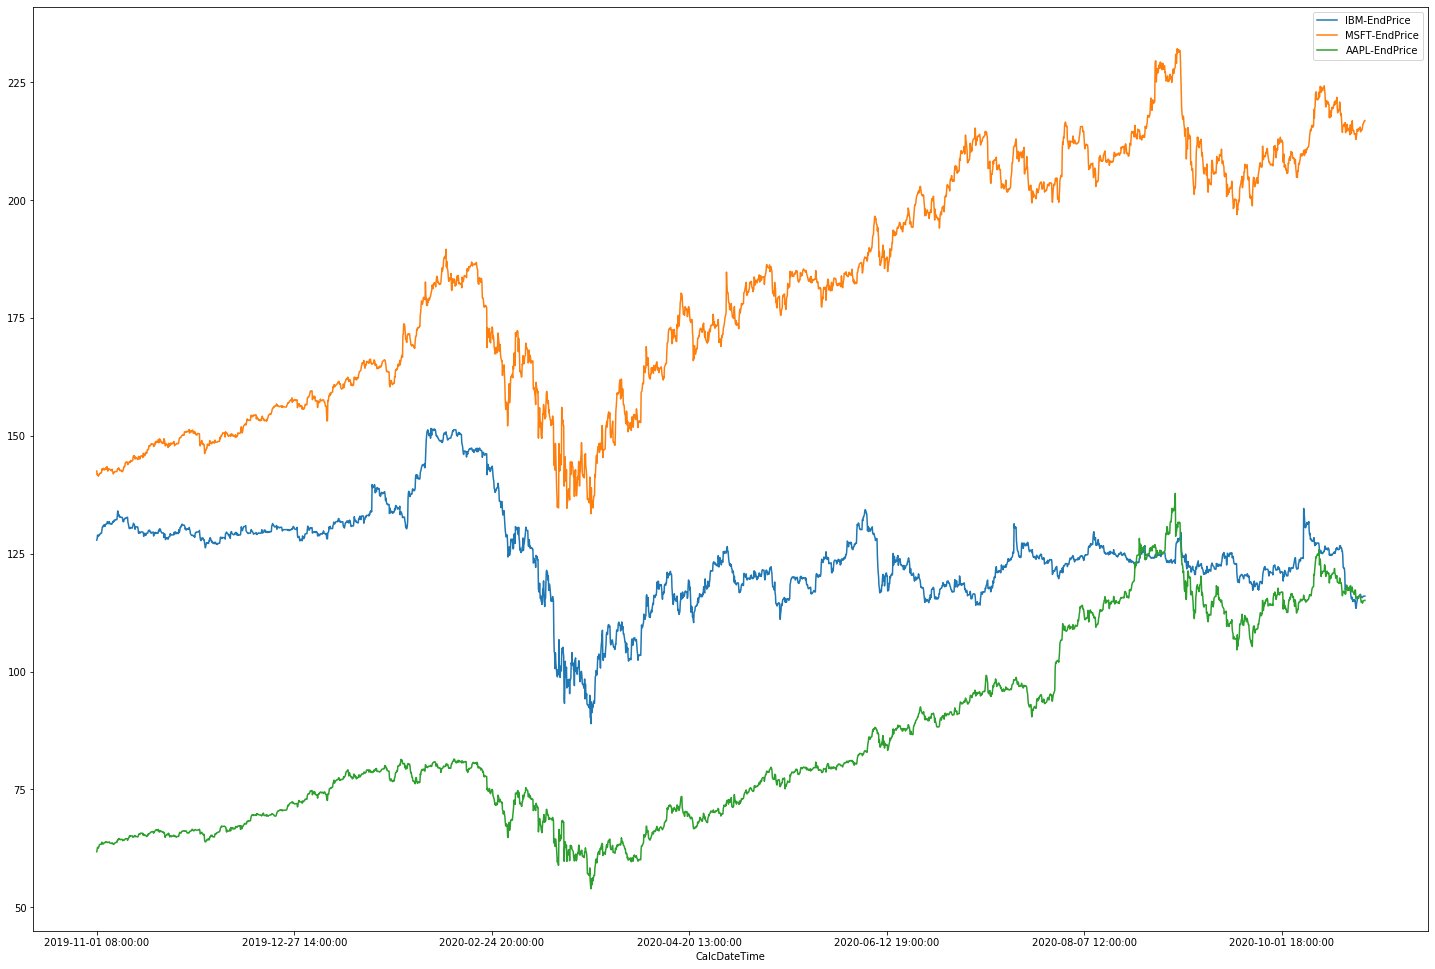

In [22]:
timeseries_plot(['IBM', 'MSFT',  'AAPL'], ['EndPrice'], interval = 'H', bucket = s3_bucket, s3_key = s3_data_key)


Now, in order to develop an intuition on how different time series for a single stock might influence each other,  we plot some metrices alongside each other, that might be somehow related, for a sample stock, in this case we just used "BMW".


Since the data set gives minute by minute observation of values, it might clutter the visual plot when it comes to understanding the patterns in the data, use data resampled at higher interval rate, such as daily or weekly.<br>


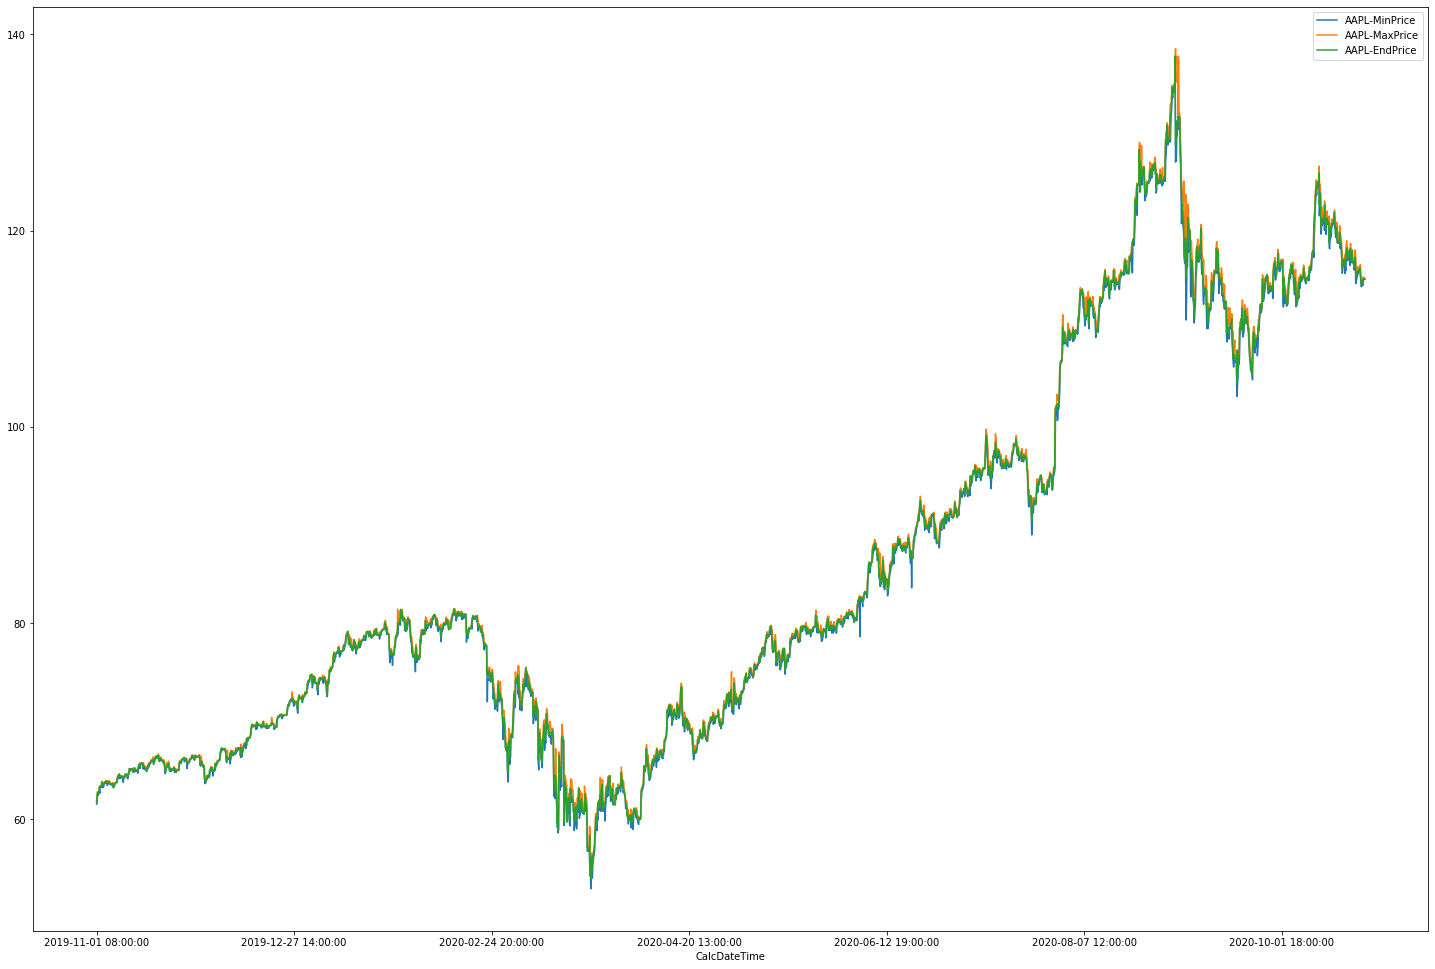

In [23]:
timeseries_plot(['AAPL'], ['EndPrice', 'MinPrice', 'MaxPrice'], interval = 'H', bucket = s3_bucket, s3_key = s3_data_key)

### Observation 1

We can observed from the graph above:

- When there is a downward trend, the `EndPrice` is closer to the `MinPrice`, than to the `MaxPrice`
- When there is an upward trend, the `EndPrice` is closer to `MaxPrice` than to the `MinPrice`

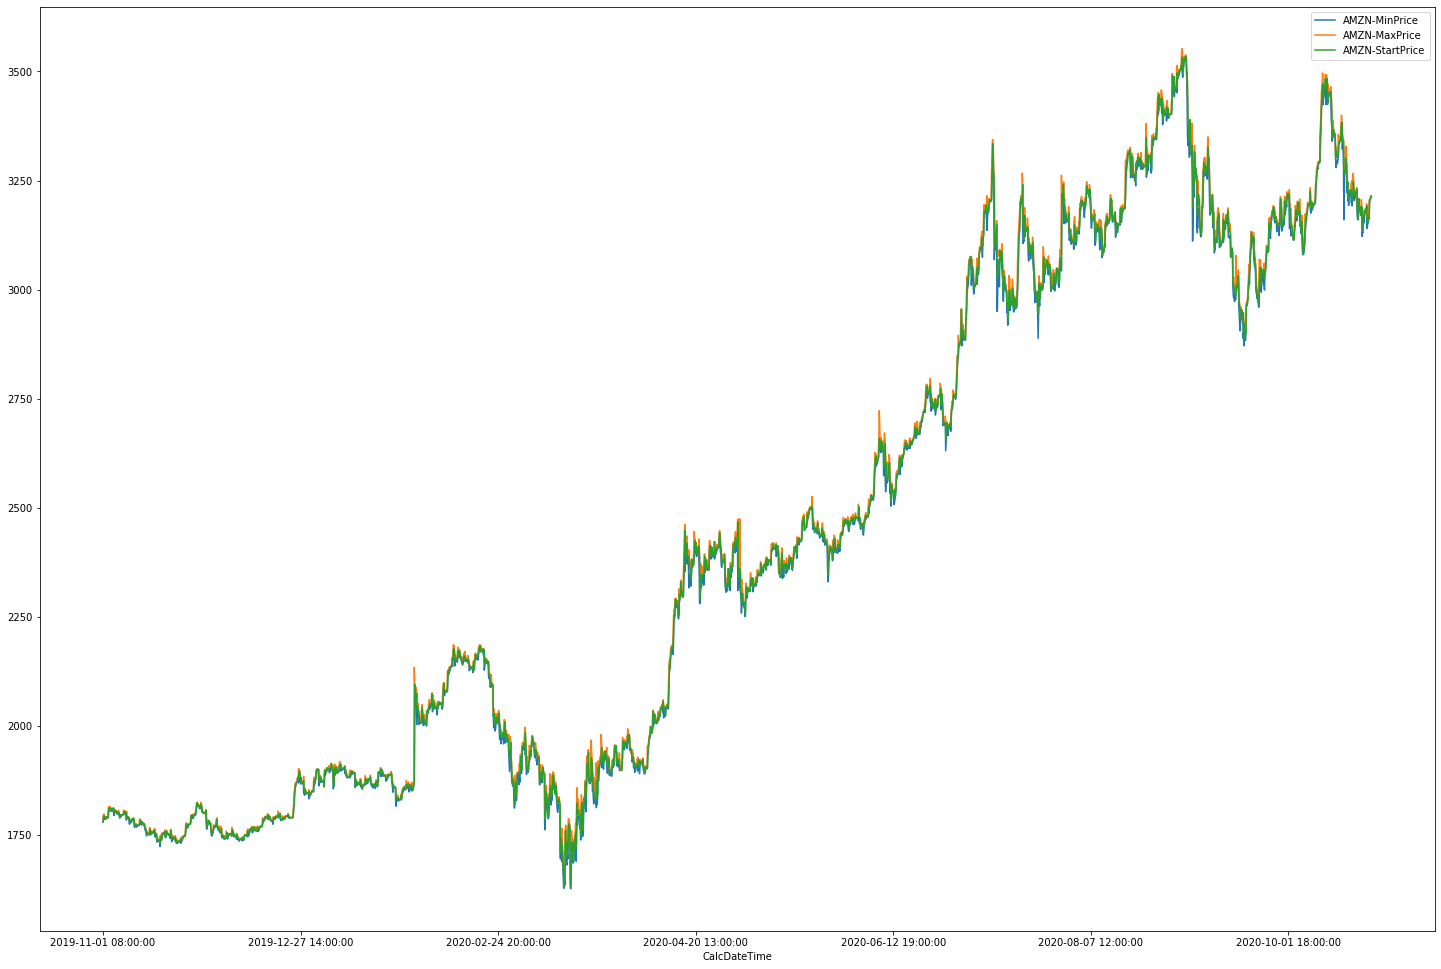

In [24]:
timeseries_plot(['AMZN'], ['StartPrice', 'MinPrice', 'MaxPrice'], interval = 'H', bucket = s3_bucket, s3_key = s3_data_key)

### Observation 2
Similar (and correlated) behavior is true for the `StartPrice`:

- When there is a downward trend, the `StartPrice` is closer to the `MaxPrice`, than to the `MinPrice`
- When there is an upward trend, the `StartPrice` is closer to `MinPrice` than to the `MaxPrice`

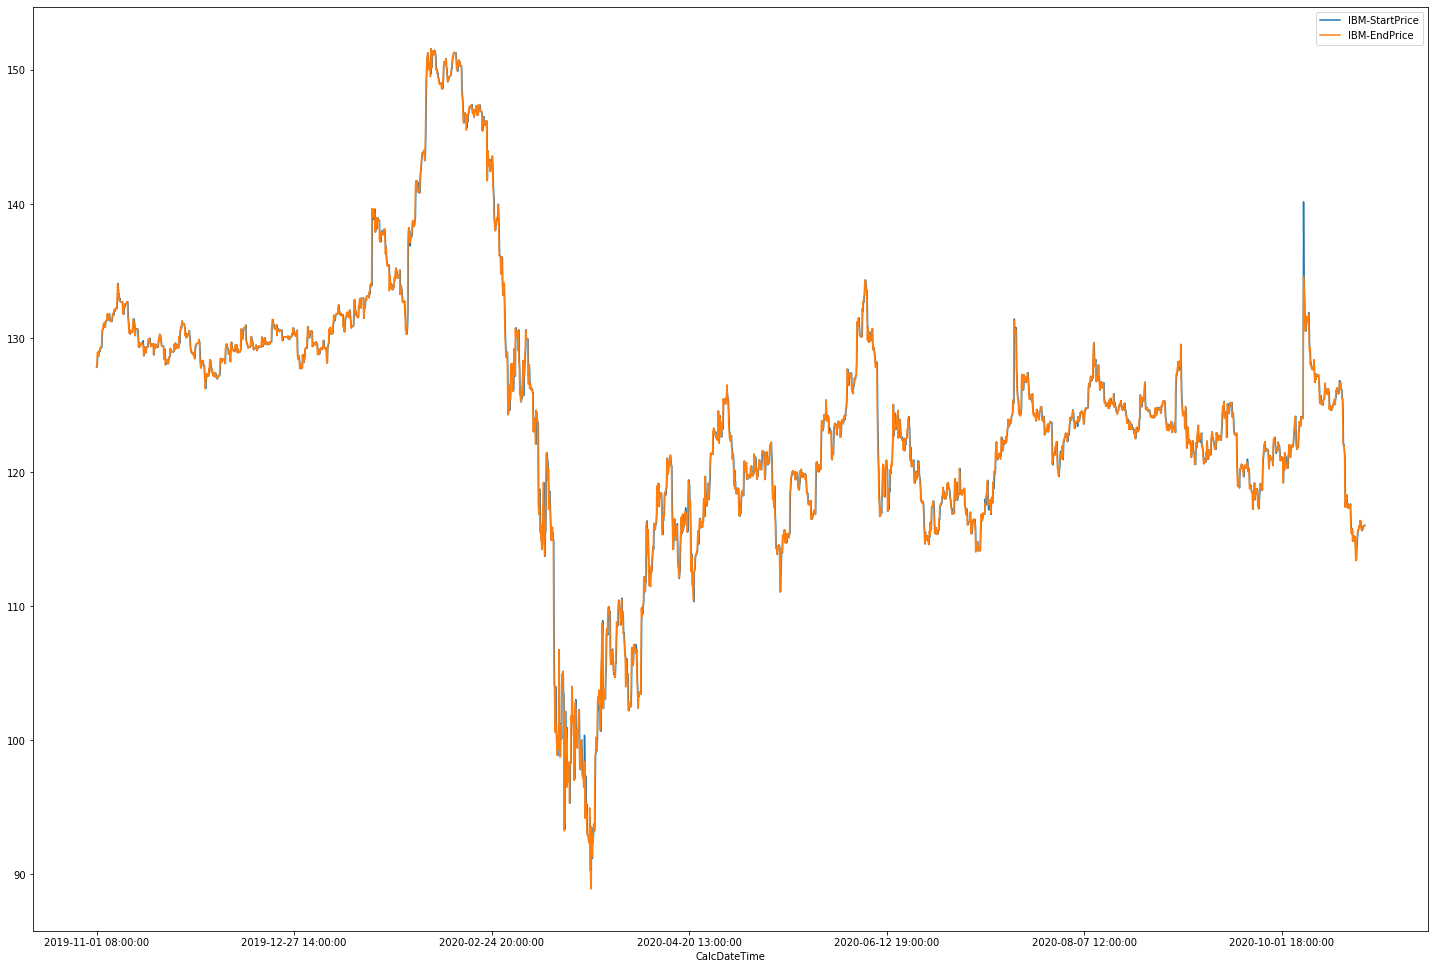

In [25]:
timeseries_plot(['IBM'], ['StartPrice', 'EndPrice'], interval = 'H', bucket = s3_bucket, s3_key = s3_data_key)

### Observation 3

Another observation that can be made is that:
- when the trend is upwards, `EndPrice` is above `StartPrice`
- when the trend is downwars, `EndPrice` is below `StartPrice`
    
Therefore: if the lines of `EndPrice` and `StartPrice` cross, one could expect trend reversal.
(Of course one needs to account for the variance, and false positives)

With these observations, we develop intuition that behaviour of the various metrices present in the data might have a correlation with future movement of the time series.<br>


In the next step we apply Deep Neural Networks based Machine Learning techniques to try and find the correlation and hopefully be able to predict future movement, with certain confidence level.